In [37]:
import xarray as xr
import numpy as np
import intake
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import sys; import os
sys.path.append(os.path.dirname('../workflow'))
from workflow.scripts.plotting_tools import create_facet_plot, global_map
import xesmf
import matplotlib as mpl
from pyclim_noresm.general_util_funcs import global_avg

In [27]:
def reorder_lons(ds):
    x = ds.cf['X'].name
    if ds.lon.max() > 180:
        ds = ds.assign_coords({x:((ds.coords[x] + 180) % 360 - 180)}).sortby(x)
        ds=ds.cf.add_bounds(['lon','lat'])
    return ds


In [13]:
col = intake.open_esm_datastore("../catalogues/merge_CMIP6.json")

trop_ozone_giss_2xdust = col.search(experiment_id=['piClim-2xdust'], source_id='GISS-E2-1-G', variable_id='tropoz',  table_id='AERmon').to_dataset_dict()
trop_ozone_giss_ctrl = col.search(experiment_id=['piClim-control'], source_id='GISS-E2-1-G', variable_id='tropoz',  table_id='AERmon').to_dataset_dict()
trop_ozone_ecEarth_ctrl = col.search(experiment_id=['piClim-control'], source_id='EC-Earth3-AerChem', variable_id='tropoz',  table_id='AERmon').to_dataset_dict()
trop_ozone_ecEarth_2xdust = col.search(experiment_id=['piClim-2xdust'], source_id='EC-Earth3-AerChem', variable_id='tropoz',  table_id='AERmon').to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id'


In [28]:
tropoz_giss_2xdust = trop_ozone_giss_2xdust['AerChemMIP.NASA-GISS'].resample(time='1Y').mean().isel(time=slice(1,None)).mean(dim='time')
tropoz_giss_ctrl = trop_ozone_giss_ctrl['RFMIP.NASA-GISS'].resample(time='1Y').mean().mean(dim='time')
tropoz_ecEarth_2xdust = trop_ozone_ecEarth_2xdust['AerChemMIP.EC-Earth-Consortium'].resample(time='1Y').mean().isel(time=slice(1,None)).mean(dim='time')
tropoz_ecEarth_ctrl = trop_ozone_ecEarth_ctrl['RFMIP.EC-Earth-Consortium'].resample(time='1Y').mean().mean(dim='time')


In [31]:
dests_exp = {
    'EC-Earth3-AerChem': reorder_lons(tropoz_ecEarth_2xdust),
    'GISS-E2-1-G': reorder_lons(tropoz_giss_2xdust)
}
dsets_ctrl = {
    'EC-Earth3-AerChem': reorder_lons(tropoz_ecEarth_ctrl),
    'GISS-E2-1-G': reorder_lons(tropoz_giss_ctrl)
}

In [41]:
diff ={k: dests_exp[k] - dsets_ctrl[k] for k in dests_exp.keys()}
diff = {k: diff[k].isel(member_id=0) for k in diff.keys()}

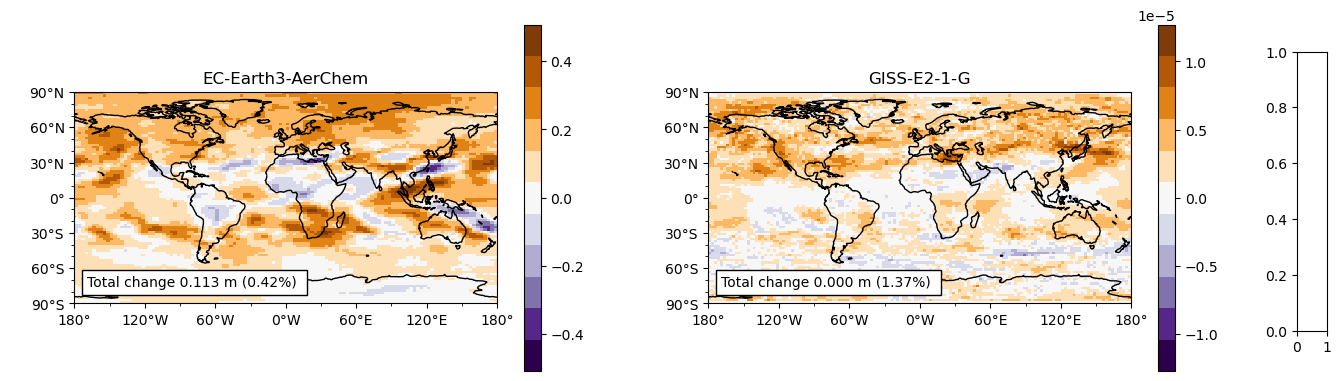

In [56]:
fig,ax, cax = create_facet_plot(figsize=(15,4.5),nplots=len(diff))

cmap = mpl.cm.PuOr_r.resampled(11)
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
for k,axk in zip(dests_exp,ax):
    
    global_map(ax=ax[axk])
    change = diff[k]['tropoz'].load()
    ctrl_glob_avg = global_avg(dsets_ctrl[k]['tropoz'].load()).isel(member_id=0)
    rel_diff = global_avg(change)/(ctrl_glob_avg)*100
    change.plot(ax=ax[axk], cmap=cmap,  add_labels=False)
    ax[axk].text(0.03, 0.08,f'Total change {float(global_avg(change).values):.3f} m ({float(rel_diff):.2f}%) ',transform=ax[axk].transAxes, 
                 bbox={'facecolor':'white'})
    ax[axk].set_title(k)
# fig.colorbar(mpl.cm.ScalarMappable(norm=norm,cmap=cmap),cax=cax, extend='both')

In [55]:
rel_diff

<xarray.DataArray (member_id: 2)>
array([ 1.36942963e+00, -1.34284005e-33])
Coordinates:
  * member_id  (member_id) object 'r1i1p3f1' 'r1i1p3f2'